## SARSA
다음 환경(**GridWorldEnvironment**)을 가지고 SARSA를 구현하세요.

## GridWorldEnvironment
```py
start_point = (0,0)
end_point = (4,4)
gridworld_size = (5,5)
env = GridWorldEnvironment(start_point, end_point, grid_world_size)
```

## Original Code

In [ ]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, grid_world_size:Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point if end_point != (-1,-1) else (grid_world_size[0] + end_point[0],
                                                                 grid_world_size[1] + end_point[1])

        # 그리드 월드의 규격을 받는다.
        self.width, self.height = grid_world_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 상태 : 좌표로 나타남
        self.traces = []

        # total states
        self.total_states = []
        for x in range(self.width):
            for y in range(self.height):
                self.total_states.append((x,y))

        # reward
        self.reward = np.zeros(shape=(self.height, self.width)).tolist() # 2차원 그리드 형태
        self.reward[end_point[0]][end_point[1]] = 1 # 목표 지점에 1 작성


    def render(self):
        # 그리드 월드의 상태 출력
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값을 삭제하기 위함
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)


    def get_reward(self, state, action_idx):
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]


    def state_after_action(self, state, action_idx:int):
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_state = (state[0]+row_movement, state[1]+col_movement)
        next_state = self.check_boundary(next_state)

        return next_state


    def check_boundary(self, state):
        state = list(state)
        state[0] = (0 if state[0] < 0 else self.height - 1 if state[0] > self.height - 1 else state[0])
        state[1] = (0 if state[1] < 0 else self.width - 1 if state[1] > self.width - 1 else state[1])
        return tuple(state)

# SARSA Class
1. 현재 상태 sₜ 에서
2. 어떤 행동 aₜ 를 수행하고
3. 실제로 벌어진 일:
   - 보상 rₜ₊₁을 받고
   - 다음 상태 sₜ₊₁로 이동하며
   - 다음 행동 aₜ₊₁를 선택
4. 그 결과를 바탕으로!
5. 처음에 했던 판단 Q(sₜ , aₜ) 가 얼마나 정확했는지 되돌아보고, 아래 수식을 따라 Q값을 수정함

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_{t+1} + \gamma \cdot Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t) \right]
$$

- 학습률 (α) : 얼마나 빠르게 학습할지
- 할인율 (γ) : 미래 보상에 대한 신뢰도

In [ ]:
env = GridWorldEnvironment(start_point=(0,0), # 위 환경 클래스를 상속 받아 `env.render` 코드를 구현
                           end_point=(4,4),
                           grid_world_size=(5,5))

<에이전트 핵심 기능 3가지>
1. Q-table 초기화 및 학습 파라미터 설정
2. ε-greedy 정책 기반 행동 선택
3. SARSA 업데이트 수식 적용

In [ ]:
class SARSAAgent:
    def __init__(self, action_space):
        # 행동 파라미터
        self.action_space = action_space
        self.num_actions = len(action_space)

        # 학습 파라미터
        self.step_size = 0.01 # 학습률
        self.discount_factor = 0.9 # 할인율
        self.epsilon = 1.0 # 탐험율 초반에 100%
        self.epsilon_decay = 0.999 # 탐험율 감소
        self.epsilon_min = 0.01 # 탐험률 최소 값 설정

        # 0을 초깃값으로 하는 큐함수 테이블 생성
        self.q_table = defaultdict(lambda: np.zeros(self.num_actions).tolist())


    def get_action(self, state): # ε-greedy 정책 기반 행동 선택
        if np.random.rand() < self.epsilon:
            action_idx = np.random.choice(range(self.num_actions)) # 탐험
        else:
            state = str(state)
            q_list = self.q_table[state]
            action_idx = self.argmax(q_list) # 큐함수 기반 최적 행동 선택

        return action_idx


    def argmax(self, q_list): # Q-table에 값이 같은 행동이 여러 개 있다면 랜덤으로 선택
        max_value = np.amax(q_list)
        max_indices = np.where(q_list == max_value)[0]
        return np.random.choice(max_indices)


    def update_q_table(self, state, action_idx, reward, next_state, next_action_idx):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # idx로 사용하기 위해 (n,n) 좌표로 표현된 state를 문자열로 생성
        state, next_state = str(state), str(next_state)

        # 시간차 제어로 Q-table 업데이트
        current_q = self.q_table[state][action_idx] # Q(sₜ, aₜ)
        next_q = self.q_table[next_state][next_action_idx] # Q(sₜ₊, aₜ₊)
        td = reward + self.discount_factor * next_q - current_q # 시간차 오류(TD error)
        new_q = current_q + self.step_size * td # SARSA 업데이트
        self.q_table[state][action_idx] = new_q 	# Q-table 반영

## Main

- **SARSA**를 이용해 그리드 월드 학습시키기  
- 학습 지표 시각화 (에피소드마다 에이전트의 이동 횟수 시각화)

In [ ]:
from collections import defaultdict

agent = SARSAAgent(env.action_space)

EPISODES = 1000
RENDER_PROCESS = False # 에이전트 이동 경로 실시간 출력 여부
RENDER_END = False # 에피소드 끝났을 때 이동 경로 출력 여부
total_moves = []

for episode in range(EPISODES):
    # 게임 환경을 초기화
    state = env.start_point # 시작점을 초기 상태로 설정
    env.current_state = state # env 객체 내부의 current_state도 업데이트 (SARSAAgent와 별개)
    env.traces = [] # traces 리스트 초기화
    moves_cnt = 0

    action_idx = agent.get_action(state) # ε-greedy 정책 기반 행동 선택
    done = False # 로 시작! 아직 에피소드(게임)이 끝나지 않았다~

    while not done:
        # 이동 경로에 현재 상태 추가
        env.traces.append(env.current_state)

        if RENDER_PROCESS:
            env.render() # 이동 출력

        # 취한 행동에 대한 next_state를 환경의 state_after_action 메서드를 사용하여 계산
        next_state = env.state_after_action(state, action_idx)

        # next_state로 에이전트의 현재 위치 업데이트 (render 메서드에서 사용됨)
        env.current_state = next_state

        # 다음 상태에서의 보상 정보를 env.reward 리스트에서 직접 가져옴
        reward = env.reward[next_state[0]][next_state[1]]

        # 다음 상태가 끝점인지 확인하여 episode 종료 여부 결정
        done = (next_state == env.end_point)

        # 다음 상태에서 행동 선택
        next_action_idx = agent.get_action(next_state)

        # 큐함수 업데이트
        agent.update_q_table(state, action_idx, reward, next_state, next_action_idx)

        # 다음 루프에서 사용할 상태/행동 업데이트
        state = next_state
        action_idx = next_action_idx
        moves_cnt += 1

    env.traces.append(env.current_state) # 에피소드가 종료될 시 최종 상태 추가
    total_moves.append(moves_cnt) # 에피소드 당 움직임 기록

    if (episode+1) % 100 == 0:
        start_index = max(0, episode - 99)
        print(f"[Episode]: {episode+1}/{EPISODES} __ [Num of Moves mean]:{np.mean(total_moves[start_index:]):.1f} __ [Epsilon]: {agent.epsilon:.3f}")


    if RENDER_END:
        env.render()

[Episode]: 100/1000 __ [Num of Moves mean]:17.2 __ [Epsilon]: 0.178
[Episode]: 200/1000 __ [Num of Moves mean]:8.9 __ [Epsilon]: 0.073
[Episode]: 300/1000 __ [Num of Moves mean]:8.4 __ [Epsilon]: 0.031
[Episode]: 400/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.014
[Episode]: 500/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 600/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 700/1000 __ [Num of Moves mean]:8.2 __ [Epsilon]: 0.010
[Episode]: 800/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 900/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 1000/1000 __ [Num of Moves mean]:8.0 __ [Epsilon]: 0.010


In [ ]:
# 마지막 학습 상황 재현
env.render()

S X X X . 
. . . X . 
. . . X . 
. . . X X 
. . . . A 



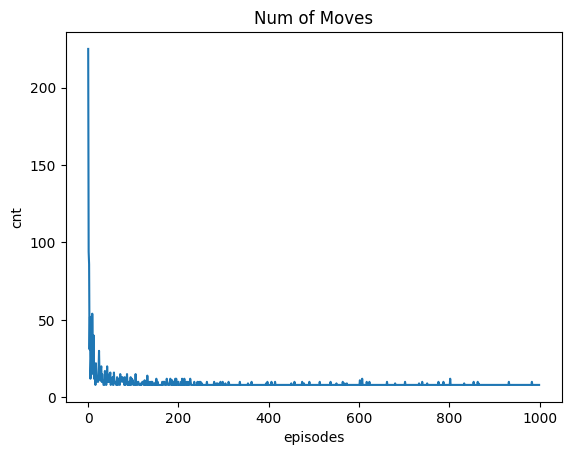

In [ ]:
# 1000 에피소드에서 에이전트 이동 횟수를 시각화
from matplotlib import pyplot as plt

plt.plot(total_moves)
plt.ylabel("cnt")
plt.xlabel("episodes")
plt.title("Num of Moves")
plt.show()